In [262]:
import numpy as np
import pandas as pd
import sklearn as sk

# Read files
train_data = pd.read_csv("train.csv")
test_df = pd.read_csv('test.csv')

In [263]:
# Drop unneeded columns
cols_to_drop = ['Cabin', 'Name', 'Ticket']
train_data = train_data.drop(columns=cols_to_drop)
test_df = test_df.drop(columns=cols_to_drop)
train_data = train_data.drop("PassengerId", axis=1)

In [264]:

DataFrame = None
Columns = []
def PandasOneHotEncodeNumpy(DataFrame, Columns):
    OutNumpyMat = None
    columnNames = []
    
    for col in Columns:
        unique_values = sorted(DataFrame[col].unique())
        one_hot = (DataFrame[col].values[:, None] == unique_values).astype(int)
        one_hot = one_hot[:, :-1]
        
        if OutNumpyMat is None:
            OutNumpyMat = one_hot
        else:
            OutNumpyMat = np.hstack((OutNumpyMat, one_hot))
        
        columnNames.extend([f"{col}_{val}" for val in unique_values[:-1]])
    
    return OutNumpyMat, columnNames

In [265]:
# One hot encode using custom function
def one_hot_encode_sex_embarked(df):
    # Remove rows where Embarked is NaN
    df = df.dropna(subset=['Embarked'])
    
    # Use custom one-hot encoding function
    encoded_matrix, column_names = PandasOneHotEncodeNumpy(df, ['Sex', 'Embarked'])
    
    # Create DataFrame with encoded features
    encoded_df = pd.DataFrame(encoded_matrix, columns=column_names, index=df.index)
    
    # Drop original categorical columns and add encoded ones
    df_encoded = df.drop(columns=['Sex', 'Embarked'])
    df_encoded = pd.concat([df_encoded, encoded_df], axis=1)
    
    return df_encoded

In [266]:
# Fill missing ages with median age
def fill_missing_ages(df):
    median_age = df['Age'].median()
    df['Age'] = df['Age'].fillna(median_age)
    return df

In [267]:
# Normalize features
def normalize_features(df, minmax_cols, standard_cols, fit_stats=None):
    df_norm = df.copy()
    if fit_stats is None:
        fit_stats = {}
        for col in minmax_cols:
            fit_stats[col] = {
                'min': df_norm[col].min(),
                'max': df_norm[col].max()
            }
        for col in standard_cols:
            fit_stats[col] = {
                'mean': df_norm[col].mean(),
                'std': df_norm[col].std()
            }
    for col in minmax_cols:
        min_val = fit_stats[col]['min']
        max_val = fit_stats[col]['max']
        df_norm[col] = (df_norm[col] - min_val) / (max_val - min_val)
    for col in standard_cols:
        mean = fit_stats[col]['mean']
        std = fit_stats[col]['std']
        df_norm[col] = (df_norm[col] - mean) / std
    if fit_stats is not None:
        return df_norm, fit_stats
    else:
        return df_norm
    
# One hot encode and fill missing ages
train_data = one_hot_encode_sex_embarked(train_data)
test_df = one_hot_encode_sex_embarked(test_df)
train_data = fill_missing_ages(train_data)
test_df = fill_missing_ages(test_df)


# Normalize features
minmax_cols = ['Pclass','Fare','Age', 'SibSp', 'Parch']
standard_cols = []
fit_stats = {}
train_data, fit_stats = normalize_features(train_data, minmax_cols, standard_cols)
test_df, _ = normalize_features(test_df, minmax_cols, standard_cols, fit_stats)


In [268]:


# Finish preparing data
# The categorical columns are already encoded using our custom function
X = train_data.drop("Survived", axis=1).values.astype(float)
y = train_data["Survived"].values.reshape(-1, 1).astype(float)

In [269]:
#Split data into training and validation sets
X_train, X_val, y_train, y_val = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
X_test = test_df.drop("PassengerId", axis=1).values.astype(float)

In [270]:
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

# Define the pipeline
pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=42))
])

# Define hyperparameter grid
param_dist = {
    'clf__n_estimators': [10, 50, 100, 200, 400, 800],  # Discrete choices
    'clf__max_depth': [8, 10, 12, None],     # Discrete choices
    'clf__min_samples_split': randint(10, 21),  # Random integers from 10-20
    'clf__min_samples_leaf': randint(5, 11),    # Random integers from 5-10
    'clf__bootstrap': [True],                   # Fixed value
    'clf__max_features': ['sqrt', 'log2', 0.6, 0.8],  # Discrete choices
}

# Setup RandomizedSearchCV with proper parameters
search = RandomizedSearchCV(
    estimator=pipeline,
    return_train_score=True,
    param_distributions=param_dist,
    n_iter=20,              # Number of parameter combinations to try
    cv=5,                   # 5-fold cross-validation
    scoring='accuracy',     # Evaluation metric
    n_jobs=-1,             # Use all available cores
    random_state=42,
    verbose=1              # Show progress
)

# Fit on training data
search.fit(X_train, y_train.ravel())

# Validation accuracy
print("Best parameters:", search.best_params_)
print("Best cross-validation score:", search.best_score_)
print("Validation accuracy:", search.score(X_val, y_val))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'clf__bootstrap': True, 'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 6, 'clf__min_samples_split': 17, 'clf__n_estimators': 200}
Best cross-validation score: 0.8283955481138578
Validation accuracy: 0.8202247191011236
Best parameters: {'clf__bootstrap': True, 'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 6, 'clf__min_samples_split': 17, 'clf__n_estimators': 200}
Best cross-validation score: 0.8283955481138578
Validation accuracy: 0.8202247191011236


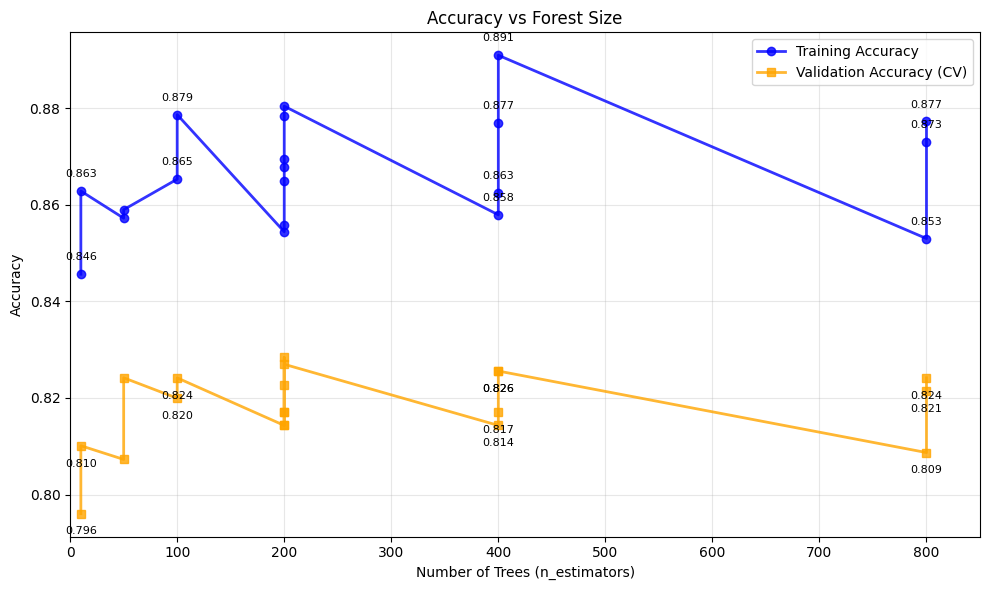

Forest Size Analysis:
----------------------------------------
Best Validation Accuracy: 0.8284 at 200 trees
Training Accuracy at Best: 0.8678
Overfitting Gap: 0.0394

All Results (sorted by forest size):


In [271]:

# Extract n_estimators and corresponding scores from the search results
n_estimators_list = []
train_acc_list = []
val_acc_list = []

for i, param_set in enumerate(search.cv_results_['params']):
    n_estimators_list.append(param_set['clf__n_estimators'])
    train_acc_list.append(search.cv_results_['mean_train_score'][i])
    val_acc_list.append(search.cv_results_['mean_test_score'][i])

# Sort by n_estimators for cleaner plotting
sorted_data = sorted(zip(n_estimators_list, train_acc_list, val_acc_list))
n_estimators_sorted, train_sorted, val_sorted = zip(*sorted_data)

# Create the Accuracy vs Forest Size plot
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_sorted, train_sorted, label='Training Accuracy', 
         marker='o', markersize=6, linewidth=2, alpha=0.8, color='blue')
plt.plot(n_estimators_sorted, val_sorted, label='Validation Accuracy (CV)', 
         marker='s', markersize=6, linewidth=2, alpha=0.8, color='orange')

plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Forest Size')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, max(n_estimators_sorted) + 50)

# Add text annotations for key points
for i, (n_est, train_acc, val_acc) in enumerate(zip(n_estimators_sorted, train_sorted, val_sorted)):
    if n_est in [10, 100, 400, 800]:  # Annotate key forest sizes
        plt.annotate(f'{train_acc:.3f}', (n_est, train_acc), 
                    textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
        plt.annotate(f'{val_acc:.3f}', (n_est, val_acc), 
                    textcoords="offset points", xytext=(0,-15), ha='center', fontsize=8)

plt.tight_layout()
plt.show()

# Print forest size analysis
print("Forest Size Analysis:")
print("-" * 40)
best_idx = np.argmax(val_sorted)
print(f"Best Validation Accuracy: {val_sorted[best_idx]:.4f} at {n_estimators_sorted[best_idx]} trees")
print(f"Training Accuracy at Best: {train_sorted[best_idx]:.4f}")
print(f"Overfitting Gap: {train_sorted[best_idx] - val_sorted[best_idx]:.4f}")
print("\nAll Results (sorted by forest size):")

# Get the full parameters for each result
full_params = []
for n_est in n_estimators_sorted:
    # Find the parameter set that matches this n_estimators
    for i, param_set in enumerate(search.cv_results_['params']):
        if param_set['clf__n_estimators'] == n_est:
            train_acc = search.cv_results_['mean_train_score'][i]
            val_acc = search.cv_results_['mean_test_score'][i]
            if train_acc in train_sorted and val_acc in val_sorted:
                full_params.append(param_set)
                break


Random Forest Implementation Comparison
Best parameters from RandomizedSearchCV: {'clf__bootstrap': True, 'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 6, 'clf__min_samples_split': 17, 'clf__n_estimators': 200}



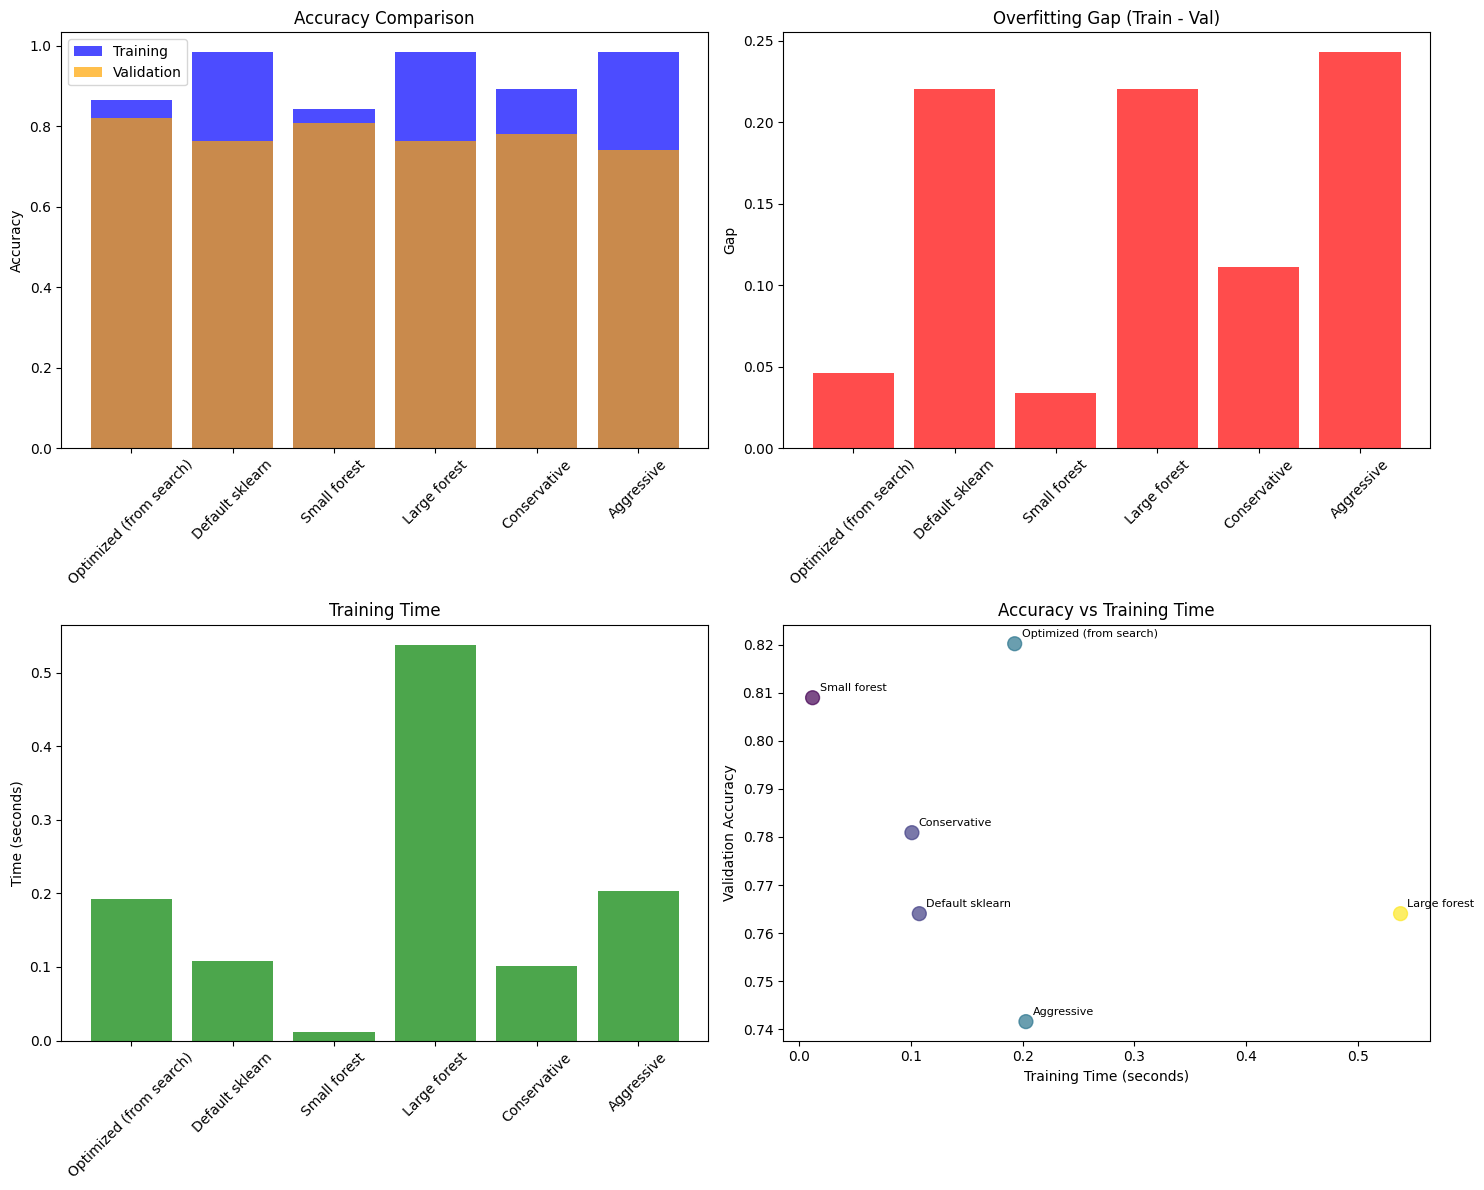


------------------------------------------------------------
GENERATING FINAL PREDICTIONS:
------------------------------------------------------------


In [272]:
# Compare Different Random Forest Implementations
import time
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

print("Random Forest Implementation Comparison")
print("=" * 60)

# Get the best parameters from our search
best_params = search.best_params_
print(f"Best parameters from RandomizedSearchCV: {best_params}")
print()

# Remove 'clf__' prefix from parameter names
clean_best_params = {k.replace('clf__', ''): v for k, v in best_params.items() if k.startswith('clf__')}

# Define different Random Forest configurations to compare
rf_configs = {
    "Optimized (from search)": {
        **clean_best_params,
        'random_state': 42
    },
    "Default sklearn": {
        'n_estimators': 100,
        'random_state': 42
    },
    "Small forest": {
        'n_estimators': 10,
        'max_depth': 5,
        'random_state': 42
    },
    "Large forest": {
        'n_estimators': 500,
        'max_depth': None,
        'random_state': 42
    },
    "Conservative": {
        'n_estimators': 100,
        'max_depth': 10,
        'min_samples_split': 10,
        'min_samples_leaf': 4,
        'random_state': 42
    },
    "Aggressive": {
        'n_estimators': 200,
        'max_depth': None,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'bootstrap': False,
        'random_state': 42
    }
}

# Compare all implementations
results = []

for name, params in rf_configs.items():
    
    # Time the training
    start_time = time.time()
    rf = RandomForestClassifier(**params)
    rf.fit(X_train, y_train.ravel())
    train_time = time.time() - start_time
    
    # Make predictions
    start_time = time.time()
    train_pred = rf.predict(X_train)
    val_pred = rf.predict(X_val)
    predict_time = time.time() - start_time
    
    # Calculate metrics
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    overfitting = train_acc - val_acc
    
    results.append({
        'Implementation': name,
        'Train_Accuracy': train_acc,
        'Val_Accuracy': val_acc,
        'Overfitting_Gap': overfitting,
        'Train_Time': train_time,
        'Predict_Time': predict_time,
        'N_Estimators': params.get('n_estimators', 100),
        'Max_Depth': params.get('max_depth', 'None'),
        'Bootstrap': params.get('bootstrap', True)
    })

# Create comparison DataFrame
comparison_df = pd.DataFrame(results)

# Find best performing models
best_val_acc = comparison_df.loc[comparison_df['Val_Accuracy'].idxmax()]
fastest_train = comparison_df.loc[comparison_df['Train_Time'].idxmin()]
least_overfitting = comparison_df.loc[comparison_df['Overfitting_Gap'].idxmin()]


# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Accuracy comparison
axes[0,0].bar(comparison_df['Implementation'], comparison_df['Train_Accuracy'], 
              alpha=0.7, label='Training', color='blue')
axes[0,0].bar(comparison_df['Implementation'], comparison_df['Val_Accuracy'], 
              alpha=0.7, label='Validation', color='orange')
axes[0,0].set_title('Accuracy Comparison')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].legend()
axes[0,0].tick_params(axis='x', rotation=45)

# Overfitting comparison
axes[0,1].bar(comparison_df['Implementation'], comparison_df['Overfitting_Gap'], 
              color='red', alpha=0.7)
axes[0,1].set_title('Overfitting Gap (Train - Val)')
axes[0,1].set_ylabel('Gap')
axes[0,1].tick_params(axis='x', rotation=45)

# Training time comparison
axes[1,0].bar(comparison_df['Implementation'], comparison_df['Train_Time'], 
              color='green', alpha=0.7)
axes[1,0].set_title('Training Time')
axes[1,0].set_ylabel('Time (seconds)')
axes[1,0].tick_params(axis='x', rotation=45)

# Validation accuracy vs training time
axes[1,1].scatter(comparison_df['Train_Time'], comparison_df['Val_Accuracy'], 
                  s=100, alpha=0.7, c=comparison_df['N_Estimators'], cmap='viridis')
axes[1,1].set_xlabel('Training Time (seconds)')
axes[1,1].set_ylabel('Validation Accuracy')
axes[1,1].set_title('Accuracy vs Training Time')

# Add labels to points
for i, row in comparison_df.iterrows():
    axes[1,1].annotate(row['Implementation'], 
                       (row['Train_Time'], row['Val_Accuracy']),
                       xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

# Generate final predictions with best model
print(f"\n{'-'*60}")
print("GENERATING FINAL PREDICTIONS:")
print(f"{'-'*60}")

# Use the best model for final predictions
best_rf = RandomForestClassifier(**rf_configs["Optimized (from search)"])
best_rf.fit(X_train, y_train.ravel())

# Make predictions on test set
y_test_pred = best_rf.predict(X_test)
y_test_pred = (y_test_pred >= 0.5).astype(int)

# Create submission file
test_df_original = pd.read_csv('test.csv')
output = pd.DataFrame({
    'PassengerId': test_df_original['PassengerId'], 
    'Survived': y_test_pred
})
output.to_csv('submission.csv', index=False)

In [275]:
# 10-Fold Cross-Validation with Confidence Intervals
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
import matplotlib.pyplot as plt

print("10-FOLD CROSS-VALIDATION WITH CONFIDENCE INTERVALS")
print("=" * 60)


preprocessing_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Get the clean best parameters from our search
clean_best_params = {k.replace('clf__', ''): v for k, v in search.best_params_.items() if k.startswith('clf__')}

# Define the two models to compare
model_configs = {
    "TOP PERFORMING MODEL (Optimized from RandomizedSearchCV)": {
        **clean_best_params,
        'random_state': 42
    },
    "LOWEST PERFORMING MODEL (Small Forest)": {
        'n_estimators': 10,
        'max_depth': 5,
        'random_state': 42
    }
}

for name, params in model_configs.items():
    print(f"\n{name}:")
    print(f"  Parameters: {params}")

# Function to compute confidence intervals
def compute_confidence_interval(scores, confidence=0.95):
    """
    Compute confidence interval for cross-validation scores
    """
    n = len(scores)
    mean = np.mean(scores)
    std_err = stats.sem(scores)  # Standard error of the mean
    
    # Use t-distribution for small sample sizes (n=10 folds)
    alpha = 1 - confidence
    t_value = stats.t.ppf(1 - alpha/2, n-1)
    
    margin_error = t_value * std_err
    ci_lower = mean - margin_error
    ci_upper = mean + margin_error
    
    return mean, std_err, ci_lower, ci_upper, margin_error

# Prepare the data (use all training data for CV)
X_full = X  # Use full dataset for cross-validation
y_full = y.ravel()

# Set up 10-fold stratified cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

results = {}

for model_name, params in model_configs.items():
    
    # Create the full pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessing_pipeline),
        ('classifier', RandomForestClassifier(**params))
    ])
    
    # Perform 10-fold cross-validation
    cv_scores = cross_val_score(pipeline, X_full, y_full, cv=cv, scoring='accuracy', n_jobs=-1)
    
    # Compute statistics and confidence intervals
    mean_acc, std_err, ci_lower, ci_upper, margin_error = compute_confidence_interval(cv_scores, confidence=0.95)
    
    # Store results
    results[model_name] = {
        'cv_scores': cv_scores,
        'mean': mean_acc,
        'std': np.std(cv_scores),
        'std_err': std_err,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'margin_error': margin_error,
        'params': params
    }

model_names = list(results.keys())
top_model = results[model_names[0]]
low_model = results[model_names[1]]

# 4. Statistical summary table (as text)
axes[1,1].axis('off')
summary_text = f"""
STATISTICAL SUMMARY

Top Model (Optimized RF):
• Mean Accuracy: {top_model['mean']:.4f}
• Std Deviation: {top_model['std']:.4f}
• 95% CI: [{top_model['ci_lower']:.4f}, {top_model['ci_upper']:.4f}]
• Margin of Error: ±{top_model['margin_error']:.4f}

Low Model (Small Forest):
• Mean Accuracy: {low_model['mean']:.4f}
• Std Deviation: {low_model['std']:.4f}
• 95% CI: [{low_model['ci_lower']:.4f}, {low_model['ci_upper']:.4f}]
• Margin of Error: ±{low_model['margin_error']:.4f}
"""

10-FOLD CROSS-VALIDATION WITH CONFIDENCE INTERVALS

TOP PERFORMING MODEL (Optimized from RandomizedSearchCV):
  Parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 17, 'n_estimators': 200, 'random_state': 42}

LOWEST PERFORMING MODEL (Small Forest):
  Parameters: {'n_estimators': 10, 'max_depth': 5, 'random_state': 42}


Cross-Validation Accuracy by Fold


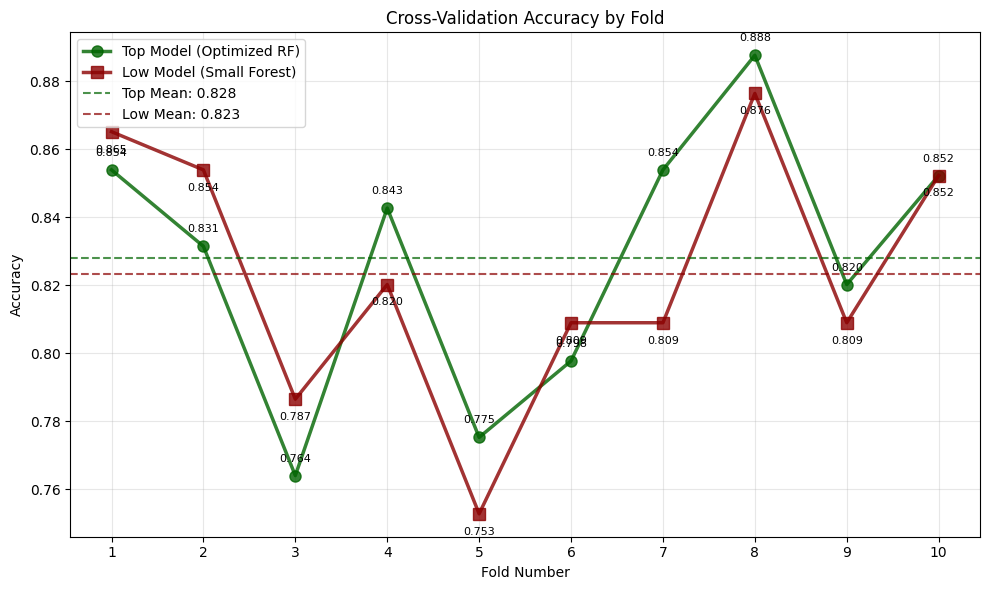


Fold-by-Fold Results:
Fold   Top Model    Low Model    Difference  
------------------------------------------------
1      0.8539       0.8652       -0.0112     
2      0.8315       0.8539       -0.0225     
3      0.7640       0.7865       -0.0225     
4      0.8427       0.8202       0.0225      
5      0.7753       0.7528       0.0225      
6      0.7978       0.8090       -0.0112     
7      0.8539       0.8090       0.0449      
8      0.8876       0.8764       0.0112      
9      0.8202       0.8090       0.0112      
10     0.8523       0.8523       0.0000      

Summary:
Top Model Mean: 0.8279
Low Model Mean: 0.8234
Overall Difference: 0.0045


In [274]:
# Cross-Validation Accuracy by Fold Plot
print("Cross-Validation Accuracy by Fold")
print("=" * 40)

# Get the results from the 10-fold CV
fold_numbers = range(1, 11)
top_scores = top_model['cv_scores']
low_scores = low_model['cv_scores']

# Create a clean, focused plot
plt.figure(figsize=(10, 6))

# Plot lines with markers for each model
plt.plot(fold_numbers, top_scores, 'o-', color='darkgreen', linewidth=2.5, 
         markersize=8, label='Top Model (Optimized RF)', alpha=0.8)
plt.plot(fold_numbers, low_scores, 's-', color='darkred', linewidth=2.5, 
         markersize=8, label='Low Model (Small Forest)', alpha=0.8)

# Add horizontal lines for means
plt.axhline(y=top_model['mean'], color='darkgreen', linestyle='--', alpha=0.7, 
            label=f'Top Mean: {top_model["mean"]:.3f}')
plt.axhline(y=low_model['mean'], color='darkred', linestyle='--', alpha=0.7, 
            label=f'Low Mean: {low_model["mean"]:.3f}')

# Formatting
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Accuracy by Fold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(fold_numbers)

# Add value annotations on points
for i, (fold, top_acc, low_acc) in enumerate(zip(fold_numbers, top_scores, low_scores)):
    plt.annotate(f'{top_acc:.3f}', (fold, top_acc), 
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
    plt.annotate(f'{low_acc:.3f}', (fold, low_acc), 
                 textcoords="offset points", xytext=(0,-15), ha='center', fontsize=8)

plt.tight_layout()
plt.show()

# Print the fold-by-fold results table
print(f"\nFold-by-Fold Results:")
print(f"{'Fold':<6} {'Top Model':<12} {'Low Model':<12} {'Difference':<12}")
print("-" * 48)
for i, (fold, top_acc, low_acc) in enumerate(zip(fold_numbers, top_scores, low_scores)):
    diff = top_acc - low_acc
    print(f"{fold:<6} {top_acc:<12.4f} {low_acc:<12.4f} {diff:<12.4f}")

print(f"\nSummary:")
print(f"Top Model Mean: {top_model['mean']:.4f}")
print(f"Low Model Mean: {low_model['mean']:.4f}")
print(f"Overall Difference: {top_model['mean'] - low_model['mean']:.4f}")